# Creating a dataloader and pre-processing our data

## 0. Before we start

This notebook is used to demonstrate how to create a dataloader on a **mock** dataset, which resembles the one, which will be used for the small project in the SUTD 50.039 Deep Learning class (Y2021).

This notebook intends to demonstrate a way to create dataloaders from scratch, i.e. just a folder containing several images, so that it can later be fed into our PyTorch model.

It consists of four parts:
1. Getting familiar with the demo dataset and the images it contains.
2. Creating a dataset object in general, and later, specific ones for training, testing and validation datasets.7
3. Using torch to transform said dataset into a dataloader,
4. and later use the said DataLoader in the training of a simple PyTorch model.

It relies on the following libraries:
- Matplotlib for displaying images in matplotlib plots,
- Numpy for numerical operations on tensors/arrays,
- Pillow (PIL) for opening images,
- and torch/torchvision for typical operations on tensors, datasets and dataloaders.

In [1]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Pillow
from PIL import Image
# Torch
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms

## 1. Getting familiar with the dataset

The images stored in the **./dataset_demo** folder and its subfolder consists of 150 by 150 pixels greyscale images, representing X-Ray pictures of lungs. 

The images, consists of X-ray pictures of infected lungs diagnosed with covid (class with index 2 and label 'infected(covid)') or infected lungs but not diagnosed with covid (class with index 1 and label 'infected(non_covid)') or people with no infection diagnosis (class with index 0 and label 'normal').

The dataset has been split into training, testing and validation sets, containing several non-identical pictures.

Each subset is stored in a different subfolder of the ./dataset/ folder, as listed in the dictionary below.

In [6]:
# Path to images for different parts of the dataset
dataset_paths = {'train_normal': './dataset/train/normal/',\
                 'train_infected(non_covid)': './dataset/train/infected/non-covid/',\
                 'train_infected(covid)': './dataset/train/infected/covid/',\
                 'val_normal': './dataset/val/normal/',\
                 'val_infected(non_covid)': './dataset/val/infected/non-covid/',\
                 'val_infected(covid)': './dataset/val/infected/covid/',\
                 'test_normal': './dataset/test/normal/',\
                 'test_infected(non_covid)': './dataset/test/infected/non-covid/',\
                 'test_infected(covid)': './dataset/test/infected/covid/'}
print(dataset_paths)

{'train_normal': './dataset/train/normal/', 'train_infected(non_covid)': './dataset/train/infected/non-covid', 'train_infected(covid)': './dataset/train/infected/covid', 'val_normal': './dataset/val/normal/', 'val_infected(non_covid)': './dataset/val/infected/non-covid', 'val_infected(covid)': './dataset/val/infected/covid', 'test_normal': './dataset/test/normal/', 'test_infected(non_covid)': './dataset/test/infected/non-covid', 'test_infected(covid)': './dataset/test/infected/covid'}


The images can simply be opened by using their full path and the open function of the PIL.Image library. It can then be displayed on screen using matplotlib. Note that the pictures are greyscale, but for readability, matplotlib will display them using an automatic color mapping.

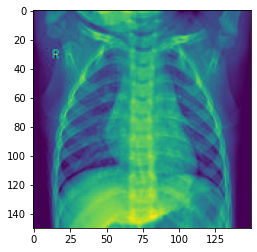

In [11]:
# Display an image
path_to_file = './dataset/train/normal/1.jpg'
with open(path_to_file, 'rb') as f:
    im = np.asarray(Image.open(f))
    plt.imshow(im)
f.close()

As expected, the images are 150 by 150 pixels images.

In [10]:
# Image shape is indeed 150 x 150
print(im.shape)

(150, 150)


And these images consist of a Numpy array (thanks to the np.asarray() operation in the previous cell), with values ranging between 0 and 255. Later on, we will have to normalize these values.

In [11]:
# Images are defined as a Numpy array of values between 0 and 256
print(im)

[[15 25 33 ... 30 26 19]
 [16 25 33 ... 30 25 19]
 [17 26 34 ... 29 25 19]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


### 2 Creating a train Dataset object

In practice however, one likes to define several datasets, for each subgroup (train, test, validation). This class however, will only be used to load images from the ./dataset_demo/train/ folder. It woks roughly as the previous Lung_Dataset class. In practice, we could have inherited Lung_Train_Dataset from Lung_Dataset, but we normally do not bother creating a general Dataset object like Lung_Dataset in Section 2.a.

The Lung_Train_Dataset object resembles to the Lung_Dataset as it contains restricted versions of the same attributes we had in the Lung_Dataset object.

It however contains two additional (special) methods, which need to be defined if we want to transform our Lung_Train_Dataset object into a dataloader later on.

The first method is the special length method ( __ len __ ), which should return the number of images present in the dataset. Lucky for us, it can be easily computed using the dataset_numbers attribute of our object.

The second one is the special getitem method ( __ getitem __ ), which is used to fetch an image and its label, using a single index value.

By convention here, we have decided to open the image in ./dataset_demo/train/normal/XXX.jpg, if the value in XXX is strictly lower than 36, which is the number of images in the ./dataset_demo/train/normal/ folder.

Otherwise, we open the image in ./dataset_demo/train/infected/YYY.jpg, where YYY is simply defined as YYY = XXX - 36.

Note that if the value in XXX is larger than the length of the dataset, i.e. 36 + 34 = 70, then no image will be opened and the getitem will display an error, based on the asserts we have in the open_img method.

Finally, the getitem method will return the image, along with a one-hot vector corresponding to the class of the object, i.e. [1, 0] for normal class and [0, 1] for infected class. Both returned parameters will be torch tensors.

In [22]:
class Lung_Train_Dataset(Dataset):
    
    def __init__(self):
        """
        Constructor for generic Dataset class - simply assembles
        the important parameters in attributes.
        """
        
        # All images are of size 150 x 150
        self.img_size = (150, 150)
        
        # Only two classes will be considered here (normal and infected)
        self.classes = {0: 'normal', 1: 'infected(non_covid)', 2: 'infected(covid)'}
        
        # The dataset consists only of training images
        self.groups = 'train'
        
        # Number of images in each part of the dataset
        self.dataset_numbers = {'train_normal': 1341,\
                                'train_infected(non_covid)': 2530,\
                                'train_infected(covid)': 1345}
        
        # Path to images for different parts of the dataset
        self.dataset_paths = {'train_normal': './dataset/train/normal/',\
                              'train_infected(non_covid)': './dataset/train/infected/non-covid/',\
                              'train_infected(covid)': './dataset/train/infected/covid/'}
        
        
    def describe(self):
        """
        Descriptor function.
        Will print details about the dataset when called.
        """
        
        # Generate description
        msg = "This is the training dataset of the Lung Dataset"
        msg += " used for the Small Project in the 50.039 Deep Learning class"
        msg += " in Feb-March 2021. \n"
        msg += "It contains a total of {} images, ".format(sum(self.dataset_numbers.values()))
        msg += "of size {} by {}.\n".format(self.img_size[0], self.img_size[1])
        msg += "The images are stored in the following locations "
        msg += "and each one contains the following number of images:\n"
        for key, val in self.dataset_paths.items():
            msg += " - {}, in folder {}: {} images.\n".format(key, val, self.dataset_numbers[key])
        print(msg)
        
    
    def open_img(self, group_val, class_val, index_val):
        """
        Opens image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal' or 'infected(non_covid)' or 'infected(covid)'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        
        Returns loaded image as a normalized Numpy array.
        """
        
        # Asserts checking for consistency in passed parameters
        err_msg = "Error - group_val variable should be set to 'train', 'test' or 'val'."
        assert group_val in self.groups, err_msg
        
        err_msg = "Error - class_val variable should be set to 'normal' or 'infected(non_covid)' or 'infected(covid)'."
        assert class_val in self.classes.values(), err_msg
        
        max_val = self.dataset_numbers['{}_{}'.format(group_val, class_val)]
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images."
        err_msg += "\n(In {}/{}, you have {} images.)".format(group_val, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val < max_val, err_msg
        
        # Open file as before
        path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_{}'.format(group_val, class_val)], index_val)
        with open(path_to_file, 'rb') as f:
            # Convert to Numpy array and normalize pixel values by dividing by 255.
            im = np.asarray(Image.open(f))/255
        f.close()
        return im
    

    
    def show_img(self, group_val, class_val, index_val):
        """
        Opens, then displays image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal' or 'infected(non_covid)' or 'infected(covid)'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        """

        # Open image
        im = self.open_img(group_val, class_val, index_val)
        
        # Display
        plt.imshow(im)
        
        
    def __len__(self):
        """
        Length special method, returns the number of images in dataset.
        """
        
        # Length function
        return sum(self.dataset_numbers.values())
    
    
    def __getitem__(self, index):
        """
        Getitem special method.
        
        Expects an integer value index, between 0 and len(self) - 1.
        
        Returns the image and its label as a one hot vector, both
        in torch tensor format in dataset.
        """
        
        # Get item special method
        first_val = int(list(self.dataset_numbers.values())[0])
        second_val = int(list(self.dataset_numbers.values())[1])
        if index < first_val:
            class_val = 'normal'
            label = torch.Tensor([1, 0, 0])
        elif index-first_val < second_val:
            class_val = 'infected(non_covid)'
            index = index - first_val
            label = torch.Tensor([0, 1, 0])
        else:
            class_val = 'infected(covid)'
            index = index - first_val - second_val
            label = torch.Tensor([0, 0, 1])        
        im = self.open_img(self.groups, class_val, index)
        im = transforms.functional.to_tensor(np.array(im)).float()
        return im, label

We can then create our Dataset object as before and display a description of the dataset.

In [23]:
ld_train = Lung_Train_Dataset()
ld_train.describe()

This is the training dataset of the Lung Dataset used for the Small Project in the 50.039 Deep Learning class in Feb-March 2021. 
It contains a total of 5216 images, of size 150 by 150.
The images are stored in the following locations and each one contains the following number of images:
 - train_normal, in folder ./dataset/train/normal/: 1341 images.
 - train_infected(non_covid), in folder ./dataset/train/infected/non-covid/: 2530 images.
 - train_infected(covid), in folder ./dataset/train/infected/covid/: 1345 images.



The length function applied to our dataset indeed gives the total number of images in this train dataset, that is 70.

In [24]:
print(len(ld_train))

5216


Finally, using the getitem method (i.e. using square bracket indexing on our object) will produce a 150 by 150 torch tensor corresponding to our image, with normalize values. It also produces a one-hot vector, in torch tensor format as well.

In [52]:
im, class_oh = ld_train[5216]
print(im.shape)
print(im)
print(class_oh)

FileNotFoundError: [Errno 2] No such file or directory: './dataset/train/infected/covid//1345.jpg'

### 2.c. Creating a test and val Dataset object

Following the same logic in Section 2.b., we can create a Lung_Test_Dataset and a Lung_Val_Dataset object. They operate in the exact same manner as the Lung_Train_Dataset object from Section 2.b., but working on a different subfolder.

In [57]:
class Lung_Test_Dataset(Dataset):
    
    def __init__(self):
        """
        Constructor for generic Dataset class - simply assembles
        the important parameters in attributes.
        """
        
        # All images are of size 150 x 150
        self.img_size = (150, 150)
        
        # Only two classes will be considered here (normal and infected)
        self.classes = {0: 'normal', 1: 'infected(non_covid)', 2: 'infected(covid)'}
        
        # The dataset consists only of test images
        self.groups = 'test'
        
        # Number of images in each part of the dataset
        self.dataset_numbers = {'test_normal': 234,\
                                'test_infected(non_covid)': 242,\
                                'test_infected(covid)': 139}
        
        # Path to images for different parts of the dataset
        self.dataset_paths = {'test_normal': './dataset/test/normal/',\
                              'test_infected(non_covid)': './dataset/test/infected/non-covid/',\
                              'test_infected(covid)': './dataset/test/infected/covid/'}
        
        
    def describe(self):
        """
        Descriptor function.
        Will print details about the dataset when called.
        """
        
        # Generate description
        msg = "This is the test dataset of the Lung Dataset"
        msg += " used for the Small Project in the 50.039 Deep Learning class"
        msg += " in Feb-March 2021. \n"
        msg += "It contains a total of {} images, ".format(sum(self.dataset_numbers.values()))
        msg += "of size {} by {}.\n".format(self.img_size[0], self.img_size[1])
        msg += "The images are stored in the following locations "
        msg += "and each one contains the following number of images:\n"
        for key, val in self.dataset_paths.items():
            msg += " - {}, in folder {}: {} images.\n".format(key, val, self.dataset_numbers[key])
        print(msg)
        
    
    def open_img(self, group_val, class_val, index_val):
        """
        Opens image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal' or 'infected(non_covid)' or 'infected(covid)'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        
        Returns loaded image as a normalized Numpy array.
        """
        
        # Asserts checking for consistency in passed parameters
        err_msg = "Error - group_val variable should be set to 'train', 'test' or 'val'."
        assert group_val in self.groups, err_msg
        
        err_msg = "Error - class_val variable should be set to 'normal' or 'infected(non_covid)' or 'infected(covid)'."
        assert class_val in self.classes.values(), err_msg
        
        max_val = self.dataset_numbers['{}_{}'.format(group_val, class_val)] 
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images."
        err_msg += "\n(In {}/{}, you have {} images.)".format(group_val, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val < max_val, err_msg
        
        # Open file as before
        path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_{}'.format(group_val, class_val)], index_val)
        with open(path_to_file, 'rb') as f:
            # Convert to Numpy array and normalize pixel values by dividing by 255.
            im = np.asarray(Image.open(f))/255
        f.close()
        return im

    
    
    def show_img(self, group_val, class_val, index_val):
        """
        Opens, then displays image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal' or 'infected(non_covid)' or 'infected(covid)'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        """
        
        # Open image
        im = self.open_img(group_val, class_val, index_val)
        
        # Display
        plt.imshow(im)
        
        
    def __len__(self):
        """
        Length special method, returns the number of images in dataset.
        """
        
        # Length function
        return sum(self.dataset_numbers.values())
    
    
    def __getitem__(self, index):
        """
        Getitem special method.
        
        Expects an integer value index, between 0 and len(self) - 1.
        
        Returns the image and its label as a one hot vector, both
        in torch tensor format in dataset.
        """
        
        # Get item special method
        first_val = int(list(self.dataset_numbers.values())[0])
        second_val = int(list(self.dataset_numbers.values())[1])
        if index < first_val:
            class_val = 'normal'
            label = torch.Tensor([1, 0, 0])
        elif index-first_val < second_val:
            class_val = 'infected(non_covid)'
            index = index - first_val
            label = torch.Tensor([0, 1, 0])
        else:
            class_val = 'infected(covid)'
            index = index - first_val - second_val
            label = torch.Tensor([0, 0, 1])        
        im = self.open_img(self.groups, class_val, index)
        im = transforms.functional.to_tensor(np.array(im)).float()
        return im, label        

In [58]:
ld_test = Lung_Test_Dataset()
ld_test.describe()

This is the test dataset of the Lung Dataset used for the Small Project in the 50.039 Deep Learning class in Feb-March 2021. 
It contains a total of 615 images, of size 150 by 150.
The images are stored in the following locations and each one contains the following number of images:
 - test_normal, in folder ./dataset/test/normal/: 234 images.
 - test_infected(non_covid), in folder ./dataset/test/infected/non-covid/: 242 images.
 - test_infected(covid), in folder ./dataset/test/infected/covid/: 139 images.



In [59]:
print(len(ld_test))

615


In [60]:
im, class_oh = ld_test[614]
print(im.shape)
print(im)
print(class_oh)

torch.Size([1, 150, 150])
tensor([[[0.3451, 0.2667, 0.1882,  ..., 0.1255, 0.0863, 0.0471],
         [0.2863, 0.2353, 0.1961,  ..., 0.1255, 0.0902, 0.0510],
         [0.2588, 0.2275, 0.2039,  ..., 0.1176, 0.0824, 0.0431],
         ...,
         [0.1020, 0.1490, 0.1922,  ..., 0.1098, 0.1098, 0.1098],
         [0.1020, 0.1490, 0.1961,  ..., 0.1098, 0.1098, 0.1098],
         [0.1059, 0.1529, 0.2000,  ..., 0.1098, 0.1098, 0.1098]]])
tensor([0., 0., 1.])


In [61]:
class Lung_Val_Dataset(Dataset):
    
    def __init__(self):
        """
        Constructor for generic Dataset class - simply assembles
        the important parameters in attributes.
        """
        
        # All images are of size 150 x 150
        self.img_size = (150, 150)
        
        # Only two classes will be considered here (normal and infected)
        self.classes = {0: 'normal', 1: 'infected(non_covid)', 2: 'infected(covid)'}
        
        # The dataset consists only of validation images
        self.groups = 'val'
        
        # Number of images in each part of the dataset
        self.dataset_numbers = {'val_normal': 8,\
                                'val_infected(non_covid)': 8,\
                                'val_infected(covid)': 9}
        
        # Path to images for different parts of the dataset
        self.dataset_paths = {'val_normal': './dataset/val/normal/',\
                            'val_infected(non_covid)': './dataset/val/infected/non-covid',\
                            'val_infected(covid)': './dataset/val/infected/covid'}
                    
        
    def describe(self):
        """
        Descriptor function.
        Will print details about the dataset when called.
        """
        
        # Generate description
        msg = "This is the validation dataset of the Lung Dataset"
        msg += " used for the Small Project in the 50.039 Deep Learning class"
        msg += " in Feb-March 2021. \n"
        msg += "It contains a total of {} images, ".format(sum(self.dataset_numbers.values()))
        msg += "of size {} by {}.\n".format(self.img_size[0], self.img_size[1])
        msg += "The images are stored in the following locations "
        msg += "and each one contains the following number of images:\n"
        for key, val in self.dataset_paths.items():
            msg += " - {}, in folder {}: {} images.\n".format(key, val, self.dataset_numbers[key])
        print(msg)
        
    
    def open_img(self, group_val, class_val, index_val):
        """
        Opens image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal' or 'infected(non_covid)' or 'infected(covid)'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        
        Returns loaded image as a normalized Numpy array.
        """
        
        # Asserts checking for consistency in passed parameters
        err_msg = "Error - group_val variable should be set to 'train', 'test' or 'val'."
        assert group_val in self.groups, err_msg
        
        err_msg = "Error - class_val variable should be set to 'normal' or 'infected(non_covid)' or 'infected(covid)'."
        assert class_val in self.classes.values(), err_msg
        
        max_val = self.dataset_numbers['{}_{}'.format(group_val, class_val)]
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images."
        err_msg += "\n(In {}/{}, you have {} images.)".format(group_val, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val < max_val, err_msg
        
        # Open file as before
        path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_{}'.format(group_val, class_val)], index_val)
        with open(path_to_file, 'rb') as f:
            # Convert to Numpy array and normalize pixel values by dividing by 255.
            im = np.asarray(Image.open(f))/255
        f.close()
        return im
    

    def show_img(self, group_val, class_val, index_val):
        """
        Opens, then displays image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal' or 'infected(non_covid)' or 'infected(covid)'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        """

        # Open image
        im = self.open_img(group_val, class_val, index_val)
        
        # Display
        plt.imshow(im)
        
        
    def __len__(self):
        """
        Length special method, returns the number of images in dataset.
        """
        
        # Length function
        return sum(self.dataset_numbers.values())
    
    
    def __getitem__(self, index):
        """
        Getitem special method.
        
        Expects an integer value index, between 0 and len(self) - 1.
        
        Returns the image and its label as a one hot vector, both
        in torch tensor format in dataset.
        """
        
        # Get item special method
        first_val = int(list(self.dataset_numbers.values())[0])
        second_val = int(list(self.dataset_numbers.values())[1])
        if index < first_val:
            class_val = 'normal'
            label = torch.Tensor([1, 0, 0])
        elif index-first_val < second_val:
            class_val = 'infected(non_covid)'
            index = index - first_val
            label = torch.Tensor([0, 1, 0])
        else:
            class_val = 'infected(covid)'
            index = index - first_val - second_val
            label = torch.Tensor([0, 0, 1])        
        im = self.open_img(self.groups, class_val, index)
        im = transforms.functional.to_tensor(np.array(im)).float()
        return im, label

In [62]:
ld_val = Lung_Val_Dataset()
ld_val.describe()

This is the validation dataset of the Lung Dataset used for the Small Project in the 50.039 Deep Learning class in Feb-March 2021. 
It contains a total of 25 images, of size 150 by 150.
The images are stored in the following locations and each one contains the following number of images:
 - val_normal, in folder ./dataset/val/normal/: 8 images.
 - val_infected(non_covid), in folder ./dataset/val/infected/non-covid: 8 images.
 - val_infected(covid), in folder ./dataset/val/infected/covid: 9 images.



In [63]:
print(len(ld_val))

25


In [69]:
im, class_oh = ld_val[15]
print(im.shape)
print(im)
print(class_oh)

torch.Size([1, 150, 150])
tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
         [0.0078, 0.0039, 0.0039,  ..., 0.0078, 0.0118, 0.0157],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]])
tensor([0., 1., 0.])


## 3. Creating a Dataloader object

The final step is to create Dataloaders, based on our previous Dataset objects. These Dataloaders will later be used for training, testing and evaluating our models in PyTorch.

The dataloaders can be simply created by using the DataLoader object from the torch.utils.data library, and by simply passing it our Dataset object. Additional parameters such as the batch_size (set to 4 for demo here) can be specified. Another interesting parameter is the shuffle = True one, which will randomly shuffle the order in which the images are selected in the Dataset.

Additional parameters for the DataLoader can be specified (see https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader for details), but it will not be necessary for this small project.

In [70]:
# Batch size value to be used (to be decided freely, but set to 4 for demo, 8 for us (cuz its the size of val det))
bs_val = 8

In [71]:
# Dataloader from dataset (train)
train_loader = DataLoader(ld_train, batch_size = bs_val, shuffle = True)
print(train_loader)

In [72]:
# Dataloader from dataset (test and val)
test_loader = DataLoader(ld_test, batch_size = bs_val, shuffle = True)
print(test_loader)
val_loader = DataLoader(ld_val, batch_size = bs_val, shuffle = True)
print(val_loader)

During the training, you will call for mini-batches using a for loop of some sort, probably similar to the one below.

Notice how each iteration of the for loop below produces a torch tensor of size [1, bs_val, 150, 150] in v[0] containing the bs_val = 4 images in the current mini-batch. You also have, in v[1], a torch tensor of size [bs_val, 2], containing the one hot vectors for each of the bs_val = 4 images.

We voluntarily interrupt it after one iteration of the mini-batch using an assert False.

In [74]:
# Typical mini-batch for loop on dataloader (train)
for k, v in enumerate(train_loader):
    print("-----")
    print(k)
    print(v[0])
    print(v[1])
    # Forced stop
    # break
    #assert False, "Forced stop after one iteration of the for loop"

-----
0
tensor([[[[0.0118, 0.0039, 0.0157,  ..., 0.0000, 0.0000, 0.0000],
          [0.0118, 0.0039, 0.0157,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0000, 0.0118,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000]]],


        [[[0.1765, 0.1922, 0.2275,  ..., 0.5294, 0.5569, 0.6000],
          [0.2627, 0.2784, 0.2941,  ..., 0.2784, 0.3098, 0.2824],
          [0.3294, 0.3451, 0.3569,  ..., 0.2196, 0.2196, 0.2471],
          ...,
          [0.0471, 0.0471, 0.0510,  ..., 0.8000, 0.8196, 0.8275],
          [0.0471, 0.0471, 0.0510,  ..., 0.8039, 0.8235, 0.8314],
          [0.0471, 0.0471, 0.0510,  ..., 0.8039, 0.8235, 0.8353]]],


        [[[0.2706, 0.2588, 0.2471,  ..., 0.2039, 0.1961, 0.1961],
          [0.2706, 0.2588, 0.2471,  ..., 0.2118, 0.2157, 0.2196],
          [0.2706, 0.2588, 0.2

KeyboardInterrupt: 

## 4. Using our dataloader for training a model

We can then use our custom dataloader for training a model.
If we decide to create a model as a subclass of the nn.Module of PyTorch, and later write a train function, as in this Notebook shown in class (https://colab.research.google.com/drive/1zhDmMfSFBy3clH-NRp9nXruQXnckZ3X1#scrollTo=KZd049wKyFT8), then our train_loader object defined in Section 3., can be directly fed to our train function in place of the train_loader.

We could for instance, define a simple (probably too simple!) model below.

In [75]:
# A simple mode
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Conv2D: 1 input channel, 8 output channels, 3 by 3 kernel, stride of 1.
        self.conv1 = nn.Conv2d(1, 4, 3, 1)
        self.fc1 = nn.Linear(87616, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        output = F.log_softmax(x, dim = 1)
        return output

In [76]:
# Create model
model = Net()

Later on, we will probably have to write a train function, which will implement a mini-batch loop, which resembles the one below. It will simply iterate on the DataLoader we have defined earlier.

In [77]:
# Try model on one mini-batch
for batch_idx, (images_data, target_labels) in enumerate(train_loader):
    predicted_labels = model(images_data)
    print(predicted_labels)
    print(target_labels)
    # Forced stop
    break
    #assert False, "Forced stop after one iteration of the mini-batch for loop"

tensor([[-0.7266, -0.6608],
        [-0.7134, -0.6733],
        [-0.7594, -0.6310],
        [-0.7320, -0.6558],
        [-0.6842, -0.7021],
        [-0.7708, -0.6211],
        [-0.7583, -0.6320],
        [-0.7750, -0.6175]], grad_fn=<LogSoftmaxBackward>)
tensor([[1., 0., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.]])


## 5. What is next?

You will have to download the full pictures repository, as specified in the Small Project instruction PDF. It will contain a much larger dataset, for which you will have to write a DataLoader. You may reuse parts of the codes presented in this notebook to come up with your custom DataLoader, if necessary.

Later on, you will have to train a model for classification, as suggested in the Small Project PDF!
Good luck!